In [2]:
import numpy as np
import pandas as pd
import json
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

# custom functions
from plotting_functions.corr_matrix import plot_corr
from plotting_functions.map_scatter import map_scatter

sns.set()

In [3]:
main_data = pd.read_csv('../data/main_dataset.csv')
main_data

FileNotFoundError: [Errno 2] No such file or directory: '../data/main_dataset.csv'

In [ ]:
old_data = pd.read_csv('../data/old_dataset.csv', index_col=0)
id_data = old_data
old_data

,id,borough,neighborhood,longitude,latitude,population,number_of_restaurants,average_review_count,average_restaurant_rating,average_price_level,yelp_category
0,nyu_2451_34572.1,Bronx,Wakefield,-73.847201,40.894705,21242.0,13,169,4.0,1,caribbean
1,nyu_2451_34572.2,Bronx,Co-op City,-73.829939,40.874294,43752.0,12,771,4.0,2,delis
2,nyu_2451_34572.3,Bronx,Eastchester,-73.827806,40.887556,11506.0,19,532,4.1,1,caribbean
3,nyu_2451_34572.4,Bronx,Fieldston,-73.905643,40.895437,9287.0,9,297,4.4,1,N
4,nyu_2451_34572.5,Bronx,Riverdale,-73.912585,40.890834,9287.0,14,319,4.0,2,burgers
...,...,...,...,...,...,...,...,...,...,...,...
301,nyu_2451_34572.302,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0,20,848,4.3,2,newamerican
302,nyu_2451_34572.303,Queens,Hammels,-73.805530,40.587338,12295.0,17,257,4.3,2,chicken_wings
303,nyu_2451_34572.304,Queens,Bayswater,-73.765968,40.611322,25029.0,0,0,0.0,0,N
304,nyu_2451_34572.305,Queens,Queensbridge,-73.945631,40.756091,6677.0,17,222,4.1,2,tradamerican


In [ ]:
# let's only take features that are interesting
old_data = old_data[['average_restaurant_rating', 'average_price_level']]
old_data

,average_restaurant_rating,average_price_level
0,4.0,1
1,4.0,2
2,4.1,1
3,4.4,1
4,4.0,2
...,...,...
301,4.3,2
302,4.3,2
303,0.0,0
304,4.1,2


In [ ]:
# let's get our encoded yelp_types
yelp_types = pd.read_csv('../data/data/yelp_restaurant_type_counts.csv').drop('Unnamed: 0', axis=1)
yelp_types

,caribbean,breakfast_brunch,pizza,burgers,sandwiches,comfortfood,soulfood,grocery,cafes,chinese,...,airportlounges,surfshop,media,shavedice,pretzels,srilankan,southafrican,personalchefs,homedecor,syrian
0,4.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,1.0,4.0,3.0,2.0,5.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.0,3.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
all_features = pd.read_csv('../data/data/all_features_counts_v3.csv', index_col=0).drop(['population','index'], axis=1)
all_features

,lodging,restaurant,school,health,bar,church,bank,store,clothing,tourist attraction,...,pharmacy,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,9,55,26,13,10,60,12,36,19,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,39,26,7,4,25,15,37,34,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,33,16,3,11,23,4,36,13,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,54,27,7,14,5,24,19,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,20,25,9,16,12,23,19,5,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,39,60,60,20,60,37,60,60,60,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,3,44,6,9,8,20,3,33,6,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,4,32,15,6,2,18,7,34,12,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,19,59,36,10,19,25,12,36,7,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# New Features

In [ ]:
geo_info = main_data.loc[:,:'population']
geo_info

,borough,neighborhood,longitude,latitude,population
0,Bronx,Wakefield,-73.847201,40.894705,21242.0
1,Bronx,Co-op City,-73.829939,40.874294,43752.0
2,Bronx,Eastchester,-73.827806,40.887556,11506.0
3,Bronx,Fieldston,-73.905643,40.895437,9287.0
4,Bronx,Riverdale,-73.912585,40.890834,9287.0
...,...,...,...,...,...
301,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0
302,Queens,Hammels,-73.805530,40.587338,12295.0
303,Queens,Bayswater,-73.765968,40.611322,25029.0
304,Queens,Queensbridge,-73.945631,40.756091,6677.0


In [ ]:
main_features = main_data.loc[:,'restaurant_count':]

In [ ]:
# scaling
scaler = MinMaxScaler()
main_features_scaled = pd.DataFrame(scaler.fit_transform(all_features), columns=all_features.columns)
main_features_scaled

,lodging,restaurant,school,health,bar,church,bank,store,clothing,tourist attraction,...,pharmacy,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,0.150000,0.916667,0.433333,0.216667,0.166667,1.000000,0.200000,0.600000,0.316667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.083333,0.650000,0.433333,0.116667,0.066667,0.416667,0.250000,0.616667,0.566667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.050000,0.550000,0.266667,0.050000,0.183333,0.383333,0.066667,0.600000,0.216667,0.027027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.033333,0.900000,0.450000,0.116667,0.233333,0.083333,0.400000,0.316667,0.066667,0.108108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.050000,0.333333,0.416667,0.150000,0.266667,0.200000,0.383333,0.316667,0.083333,0.054054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0.650000,1.000000,1.000000,0.333333,1.000000,0.616667,1.000000,1.000000,1.000000,0.324324,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.050000,0.733333,0.100000,0.150000,0.133333,0.333333,0.050000,0.550000,0.100000,0.027027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.066667,0.533333,0.250000,0.100000,0.033333,0.300000,0.116667,0.566667,0.200000,0.054054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.316667,0.983333,0.600000,0.166667,0.316667,0.416667,0.200000,0.600000,0.116667,0.108108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# # scaling
# scaler = StandardScaler()
# features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
# features_scaled

# # # try MinMaxScaler
# # scaler = MinMaxScaler()
# # features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
# # features_scaled

In [ ]:
# Let's figure out the best value for eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(main_features_scaled)

distances, indices = nbrs.kneighbors(main_features_scaled)

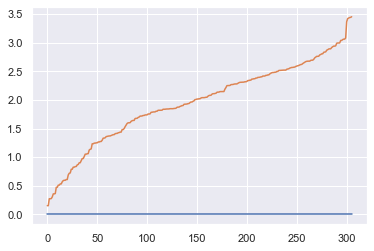

In [ ]:
# plot it
distances = np.sort(distances, axis=0)
plt.plot(distances)

In [ ]:
# between 0.5 and 1.0 seems best
dbscan = DBSCAN(
    eps=5,
    min_samples=5,
    n_jobs=-1
)

In [ ]:
# fit and predict
clusters = pd.Series(dbscan.fit_predict(main_features_scaled))
clusters.nunique()

1

# This isn't really working, let's try PCA

In [ ]:
# remove restaurant count
main_features_scaled

,lodging,restaurant,school,health,bar,church,bank,store,clothing,tourist attraction,...,pharmacy,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,0.150000,0.916667,0.433333,0.216667,0.166667,1.000000,0.200000,0.600000,0.316667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.083333,0.650000,0.433333,0.116667,0.066667,0.416667,0.250000,0.616667,0.566667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.050000,0.550000,0.266667,0.050000,0.183333,0.383333,0.066667,0.600000,0.216667,0.027027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.033333,0.900000,0.450000,0.116667,0.233333,0.083333,0.400000,0.316667,0.066667,0.108108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.050000,0.333333,0.416667,0.150000,0.266667,0.200000,0.383333,0.316667,0.083333,0.054054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0.650000,1.000000,1.000000,0.333333,1.000000,0.616667,1.000000,1.000000,1.000000,0.324324,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.050000,0.733333,0.100000,0.150000,0.133333,0.333333,0.050000,0.550000,0.100000,0.027027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.066667,0.533333,0.250000,0.100000,0.033333,0.300000,0.116667,0.566667,0.200000,0.054054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.316667,0.983333,0.600000,0.166667,0.316667,0.416667,0.200000,0.600000,0.116667,0.108108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Variance Explained')

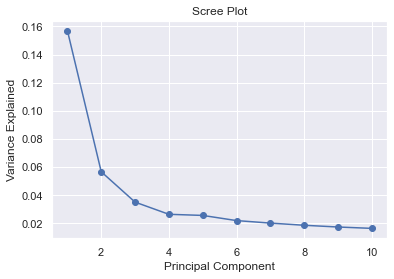

In [ ]:
# How many PCs do we want?

pca = PCA(n_components=10)
pca_fit = pca.fit(main_features_scaled)
pca_fit

PC_values = np.arange(pca.n_components_) + 1
PC_values

plt.plot(PC_values, pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

In [ ]:
# # 3 is the ideal PCA
# pca = PCA(n_components=3)
# features_pca = pd.DataFrame(pca.fit_transform(main_features_scaled), columns=['PC1','PC2','PC3'])
# features_pca

# Let's try 5
pca = PCA(n_components=5)
features_pca = pd.DataFrame(pca.fit_transform(main_features_scaled), columns=['PC1','PC2','PC3','PC4','PC5'])
features_pca

,PC1,PC2,PC3,PC4,PC5
0,-0.350819,0.709996,-0.264307,-0.381811,0.446031
1,-0.563931,0.427026,-0.118312,0.027584,0.339493
2,-0.587661,0.325325,-0.084414,-0.237159,0.235757
3,-0.582338,-0.307512,0.180171,-0.151716,-0.251314
4,-0.560793,-0.137340,0.410400,0.043671,-0.371353
...,...,...,...,...,...
301,1.918999,-0.716384,-0.082292,-0.004894,-0.163672
302,-0.532640,-0.393494,-0.153382,-0.221756,-0.170022
303,-0.853634,-0.350324,-0.581625,0.124334,-0.011283
304,0.233332,-0.019982,0.183264,-0.425912,0.043471


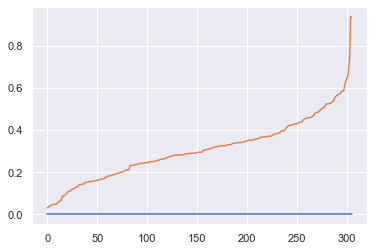

In [ ]:
# Let's figure out the best value for eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features_pca)

distances, indices = nbrs.kneighbors(features_pca)

# plot it
distances = np.sort(distances, axis=0)
plt.plot(distances)

In [ ]:
dbscan = DBSCAN(
    eps=.5,
    min_samples=6,
    n_jobs=-1
)

In [ ]:
# fit and predict
clusters = pd.Series(dbscan.fit_predict(features_pca))
clusters.nunique()

7

In [ ]:
# add back geo info and clusters
clustered_pca = pd.concat([geo_info, features_pca, clusters], axis=1)
clustered_pca = clustered_pca.rename(columns={0:'cluster'})

In [ ]:
clustered_pca

,borough,neighborhood,longitude,latitude,population,PC1,PC2,PC3,PC4,PC5,cluster
0,Bronx,Wakefield,-73.847201,40.894705,21242.0,-0.350819,0.709996,-0.264307,-0.381811,0.446031,0
1,Bronx,Co-op City,-73.829939,40.874294,43752.0,-0.563931,0.427026,-0.118312,0.027584,0.339493,0
2,Bronx,Eastchester,-73.827806,40.887556,11506.0,-0.587661,0.325325,-0.084414,-0.237159,0.235757,0
3,Bronx,Fieldston,-73.905643,40.895437,9287.0,-0.582338,-0.307512,0.180171,-0.151716,-0.251314,0
4,Bronx,Riverdale,-73.912585,40.890834,9287.0,-0.560793,-0.137340,0.410400,0.043671,-0.371353,0
...,...,...,...,...,...,...,...,...,...,...,...
301,Manhattan,Hudson Yards,-74.000111,40.756658,23383.0,1.918999,-0.716384,-0.082292,-0.004894,-0.163672,4
302,Queens,Hammels,-73.805530,40.587338,12295.0,-0.532640,-0.393494,-0.153382,-0.221756,-0.170022,0
303,Queens,Bayswater,-73.765968,40.611322,25029.0,-0.853634,-0.350324,-0.581625,0.124334,-0.011283,0
304,Queens,Queensbridge,-73.945631,40.756091,6677.0,0.233332,-0.019982,0.183264,-0.425912,0.043471,-1


In [ ]:
# export for evaluation
clustered_pca.to_csv('../data/evaluation_data/dbscan_v2_clusters.csv')

In [ ]:
def DBSCANplot(data=features_pca, eps=2, min_samples=3, map_plot=True):
    dbscan = DBSCAN(
    eps=eps,
    min_samples=min_samples,
    n_jobs=-1
    )
    
    # fit and predict
    clusters = pd.Series(dbscan.fit_predict(data))
    print(clusters.nunique())

    # add back geo info and clusters
    clustered_pca = pd.concat([geo_info, features_pca, clusters], axis=1)
    clustered_pca = clustered_pca.rename(columns={0:'cluster'})

    if map_plot:
        map_scatter(clustered_pca)


    # reduce to 3D for graphing
    pca = PCA(n_components=2)
    graph_pca = pd.DataFrame(pca.fit_transform(main_features_scaled), columns=['PC1','PC2'])
    graph_pca = pd.concat([graph_pca,clusters], axis=1)
    graph_pca = graph_pca.rename(columns={0:'cluster'})


    fig = px.scatter(graph_pca, x='PC1', y='PC2',
              color='cluster')
    fig.show()

In [ ]:
clustered_pca

NameError: name 'clustered_pca' is not defined

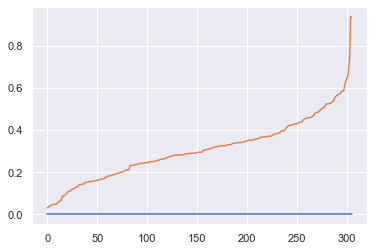

In [ ]:
# Let's figure out the best value for eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features_pca)

distances, indices = nbrs.kneighbors(features_pca)

# plot it
distances = np.sort(distances, axis=0)
plt.plot(distances)

In [ ]:
# Define variable options
eps_options = np.arange(.5,.7,.1)
min_options = np.arange(4,11,1)

In [ ]:
for eps in eps_options:
    for min in min_options:
        print('eps:' + str(eps))
        print('min:' + str(min))
        DBSCANplot(features_pca, eps, min, map_plot=False)

eps:0.5
min:4
4


eps:0.5
min:5
6


eps:0.5
min:6
7


eps:0.5
min:7
6


eps:0.5
min:8
5


eps:0.5
min:9
5


eps:0.5
min:10
4


eps:0.6
min:4
2


eps:0.6
min:5
2


eps:0.6
min:6
2


eps:0.6
min:7
2


eps:0.6
min:8
2


eps:0.6
min:9
2


eps:0.6
min:10
2


In [ ]:
# With PC3, best values are eps:1.6 and min 4
DBSCANplot(features_pca, .5,5)

6


In [ ]:
# With PC3, best values are eps:1.6 and min 4
DBSCANplot(features_pca, .5,6)

7


In [ ]:
num_top_venues = 5

# We need to remove the venue counts, it's distorting the data

### Google

In [ ]:
features_1km.sum().sort_values(ascending=False)[:30].keys()

NameError: name 'features_1km' is not defined

In [ ]:
['lodging', 'restaurant', 'school', 'health', 'bar', 'church', 'bank', 'store',
       'clothing', 'tourist attraction', 'gym', 'lawyer', 'bakery',
       'cafe', 'department store', 'university', 'local government office',
       'electronics store', 'park', 'drugstore', 'supermarket']